In [6]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import impute
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import ensemble
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn import decomposition
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [7]:
merged_train = pd.read_csv('./data/merged_train.csv')
merged_test = pd.read_csv('./data/merged_test.csv')

In [8]:
# train-validation split
X_train, X_validation, y_train, y_validation = model_selection.train_test_split(
    merged_train.drop('SK_ID_CURR', axis = 1), merged_train.TARGET,
    test_size=0.30, random_state=0, stratify=merged_train.TARGET)

# upsample
X_train_0 = X_train[X_train.TARGET == 0]
X_train_1 = X_train[X_train.TARGET == 1]
X_train_1 = X_train_1.sample(X_train_0.shape[0], replace=True)
X_train = pd.concat([X_train_0, X_train_1], axis = 0)
y_train = X_train.TARGET
X_train = X_train.drop('TARGET', axis = 1)

X_validation = X_validation.drop('TARGET', axis = 1)


# train-test split for KAGGLE entry
Xs_train = merged_train.copy()
Xs_train_0 = Xs_train[Xs_train.TARGET == 0]
Xs_train_1 = Xs_train[Xs_train.TARGET == 1]
Xs_train_1 = Xs_train_1.sample(Xs_train_0.shape[0], replace=True)
Xs_train = pd.concat([Xs_train_0, Xs_train_1], axis = 0)
ys_train = Xs_train.TARGET
Xs_train = Xs_train.drop(['SK_ID_CURR', 'TARGET'], axis = 1)

Xs_test = merged_test.drop('SK_ID_CURR', axis = 1)

In [13]:
# Validation

sgbmodel = ensemble.GradientBoostingClassifier(subsample=0.7)
param_grid = {"n_estimators": [100], "learning_rate": [0.05], "max_depth": [7]}
gridmodel = model_selection.GridSearchCV(sgbmodel, param_grid, scoring = 'roc_auc')
gridmodel.fit(X_train, y_train)

print(gridmodel.best_estimator_)
print('n_estimators:', gridmodel.best_estimator_.n_estimators, '  ',
      'learning_rate:', gridmodel.best_estimator_.learning_rate, '  ',
      'max_depth:', gridmodel.best_estimator_.max_depth)
print('train_roc:', round(gridmodel.score(X_train, y_train), 3), '  ',
      'validation_roc:', round(gridmodel.score(X_validation, y_validation), 3))

sgb = pd.DataFrame(gridmodel.cv_results_)[['param_n_estimators', 'param_learning_rate', 'param_max_depth', 
                                      'mean_test_score', 'mean_train_score', 'std_test_score']]
try:
    sgb_results = pd.concat([sgb_results, sgb])
except:
    sgb_results = sgb.copy()
sgb_results.sort_values(by = 'mean_test_score', ascending = False)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=7,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=0.7, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
n_estimators: 100    learning_rate: 0.05    max_depth: 7
train_roc: 0.849    validation_roc: 0.772


,param_n_estimators,param_learning_rate,param_max_depth,mean_test_score,mean_train_score,std_test_score
0,100,0.05,7,0.836516,0.851304,0.000818
0,100,0.05,6,0.810340,0.820337,0.000578
0,100,0.05,5,0.790373,0.796491,0.000636


In [ ]:
# n_estimators: 100    learning_rate: 0.05    max_depth: 6
# train_roc: 0.818    validation_roc: 0.771
#-------------------------------------------------------------
# n_estimators: 100    learning_rate: 0.05    max_depth: 7
# train_roc: 0.849    validation_roc: 0.772

In [ ]:
# Model fit and prediction
model = ensemble.GradientBoostingClassifier(n_estimators = 100, learning_rate = 0.05, max_depth = 7, subsample = 0.7)
model.fit(Xs_train, ys_train)
y_pred = model.predict_proba(Xs_test)

In [17]:
sol = pd.DataFrame({'SK_ID_CURR': merged_test.SK_ID_CURR, 'TARGET': y_pred[:,1]})
sol.to_csv('./soln/sol_mergedsgb.csv', index = False)                   # kaggle: 0.75127

#### ROC

In [37]:
y_prob = gridmodel.best_estimator_.predict_proba(X_validation)[ :1]
y_validation

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

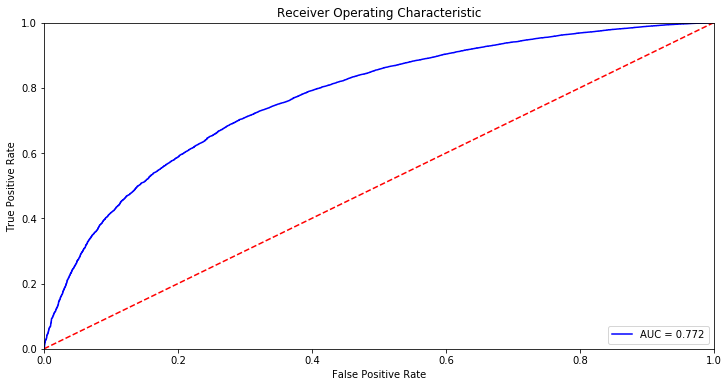

In [50]:
fpr, tpr, threshold = metrics.roc_curve(y_validation, y_prob)
roc_auc = metrics.auc(tpr, fpr)

fig = plt.figure(figsize=(12, 6))
plt.plot(tpr, fpr, 'b', label = 'AUC = {:0.3f}'.format(roc_auc))
# plt.plot(tpr, fpr, 'b', label = 'AUC = %0.3f' % roc_auc)
plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

array([1, 1, 0, ..., 0, 1, 0], dtype=int64)

In [52]:
metrics.confusion_matrix(y_validation, gridmodel.best_estimator_.predict(X_validation))

array([[63510, 21296],
       [ 2592,  4856]], dtype=int64)

In [58]:
metrics.classification_report(y_validation, gridmodel.best_estimator_.predict(X_validation), output_dict=True)

{'0': {'precision': 0.9607878732867386,
  'recall': 0.7488856920500908,
  'f1-score': 0.8417048797943119,
  'support': 84806},
 '1': {'precision': 0.18568369531966963,
  'recall': 0.6519871106337272,
  'f1-score': 0.28904761904761905,
  'support': 7448},
 'micro avg': {'precision': 0.7410627181477226,
  'recall': 0.7410627181477226,
  'f1-score': 0.7410627181477226,
  'support': 92254},
 'macro avg': {'precision': 0.5732357843032041,
  'recall': 0.700436401341909,
  'f1-score': 0.5653762494209654,
  'support': 92254},
 'weighted avg': {'precision': 0.8982109019088177,
  'recall': 0.7410627181477226,
  'f1-score': 0.7970868547976573,
  'support': 92254}}

In [62]:
print(metrics.classification_report(y_validation, gridmodel.best_estimator_.predict(X_validation), target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.96      0.75      0.84     84806
           1       0.19      0.65      0.29      7448

   micro avg       0.74      0.74      0.74     92254
   macro avg       0.57      0.70      0.57     92254
weighted avg       0.90      0.74      0.80     92254

